# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

The task is to formulate a supervised regression problem where the target variable is the car price. The objective is to analyze the dataset of used vehicles and determine the most influential features (e.g., year, mileage, manufacturer, model, condition) that explain the variation in prices. This involves data cleaning, feature engineering, exploratory data analysis (EDA), and predictive modeling to uncover patterns and build an interpretable model that can estimate or predict the price of a used car based on its attributes.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression  # or any model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso # import Ridge and Lasso



In [2]:
# Load the dataset
data = pd.read_csv('/content/data/vehicles.csv')

In [3]:
# Display basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354274 entries, 0 to 354273
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            354274 non-null  int64  
 1   region        354273 non-null  object 
 2   price         354273 non-null  float64
 3   year          353238 non-null  float64
 4   manufacturer  339414 non-null  object 
 5   model         349799 non-null  object 
 6   condition     213436 non-null  object 
 7   cylinders     207529 non-null  object 
 8   fuel          351887 non-null  object 
 9   odometer      350628 non-null  float64
 10  title_status  347779 non-null  object 
 11  transmission  352149 non-null  object 
 12  VIN           220832 non-null  object 
 13  drive         244631 non-null  object 
 14  size          99918 non-null   object 
 15  type          276979 non-null  object 
 16  paint_color   245954 non-null  object 
 17  state         354273 non-null  object 
dtypes: f

In [4]:
# Display summary statistics for numerical columns
data.describe()

,id,price,year,odometer
count,3.542740e+05,3.542730e+05,353238.000000,3.506280e+05
mean,7.311531e+09,7.574967e+04,2011.128069,9.801307e+04
std,1.306769e+07,1.180517e+07,9.514597,2.172734e+05
min,7.300000e+01,0.000000e+00,1900.000000,0.000000e+00
25%,7.308238e+09,5.900000e+03,2008.000000,3.772500e+04
50%,7.312776e+09,1.350000e+04,2013.000000,8.600000e+04
75%,7.315266e+09,2.599000e+04,2017.000000,1.339062e+05
max,7.317082e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
# Check for missing values
data.isnull().sum()

,0
id,0
region,1
price,1
year,1036
manufacturer,14860
model,4475
condition,140838
cylinders,146745
fuel,2387
odometer,3646


In [6]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

In [7]:
# Preview top rows of the dataset
data

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354269,7316258597,knoxville,5400.0,1996.0,ford,f-150,good,8 cylinders,gas,238205.0,clean,automatic,NaN,4wd,NaN,NaN,NaN,tn
354270,7316243480,knoxville,18990.0,2008.0,mercedes-benz,sl550,NaN,NaN,gas,99000.0,clean,automatic,NaN,NaN,NaN,convertible,NaN,tn
354271,7316241516,knoxville,0.0,2015.0,bmw,4 series,NaN,4 cylinders,gas,81289.0,clean,automatic,NaN,4wd,compact,sedan,brown,tn
354272,7316218608,knoxville,16995.0,2012.0,toyota,tacoma,NaN,6 cylinders,gas,191704.0,clean,automatic,3TMLU4EN1CM102745,4wd,NaN,truck,grey,tn


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [8]:
# Perform data cleaning
cleaned_data = data.copy()
cleaned_data.dropna(subset=['price', 'year', 'manufacturer', 'model'], inplace=True)
cleaned_data['cylinders'] = cleaned_data['cylinders'].astype(str)
cleaned_data.drop(columns=['id', 'VIN', 'region'], inplace=True, errors='ignore')
cleaned_data

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,33590.0,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al
28,22590.0,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al
29,39590.0,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al
30,30990.0,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al
31,15000.0,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354268,0.0,2018.0,mercedes-benz,c-class,NaN,4 cylinders,gas,35324.0,clean,automatic,rwd,compact,sedan,red,tn
354269,5400.0,1996.0,ford,f-150,good,8 cylinders,gas,238205.0,clean,automatic,4wd,NaN,NaN,NaN,tn
354270,18990.0,2008.0,mercedes-benz,sl550,NaN,nan,gas,99000.0,clean,automatic,NaN,NaN,convertible,NaN,tn
354271,0.0,2015.0,bmw,4 series,NaN,4 cylinders,gas,81289.0,clean,automatic,4wd,compact,sedan,brown,tn


Text(0, 0.5, 'Number of Cars')

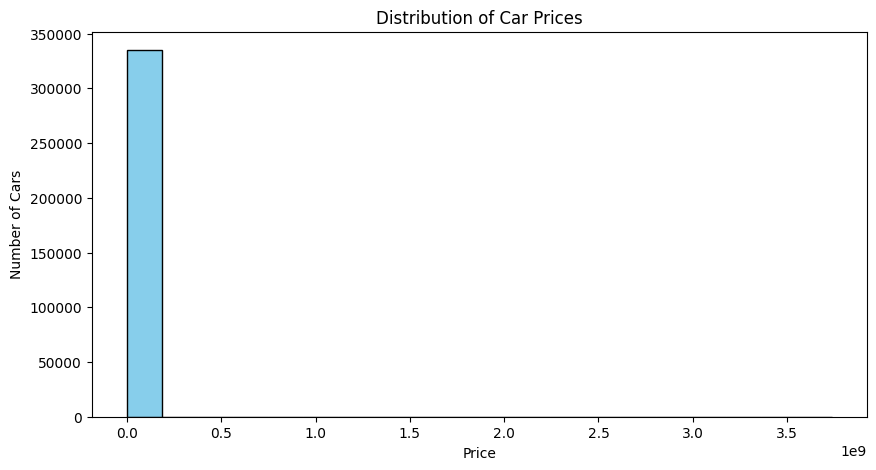

In [9]:
# Bar plot for price
plt.figure(figsize=(10, 5))
cleaned_data['price'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')

Explanation:
X-axis stretches into billions (e.g., 3.5e9 or $3.5 billion):

This is highly abnormal — clearly, some price values are erroneous outliers.

It’s possible a few rows have price values in the hundreds of millions or billions due to input errors (e.g., extra zeroes or incorrect units).

Y-axis shows all data is concentrated in the first bar:

Almost all car prices are in a much lower range, but the massive outliers stretch the x-axis so wide that everything else gets "squeezed" into the first bin.

This makes the plot useless for understanding the actual distribution of normal prices.

In [10]:
# Remove price outliers using IQR method
cleaned_data = cleaned_data = cleaned_data[cleaned_data['price'] >= 5_000].copy()
Q1 = cleaned_data["price"].quantile(0.25)
Q3 = cleaned_data["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

cleaned_data = cleaned_data[(cleaned_data["price"] >= lower_bound) & (cleaned_data["price"] <= upper_bound)]
print(lower_bound,upper_bound)

-18750.0 58450.0


In [11]:
cleaned_data['price'].value_counts()


,count
price,
7995.0,2681
6995.0,2632
8995.0,2431
9995.0,2389
5995.0,2274
...,...
21463.0,1
27871.0,1
19487.0,1


In [12]:
cleaned_data['price'].describe()

,price
count,256382.000000
mean,20409.448292
std,11803.172616
min,5000.000000
25%,9999.000000
50%,17988.000000
75%,28590.000000
max,58448.000000


Text(0, 0.5, 'Number of Cars')

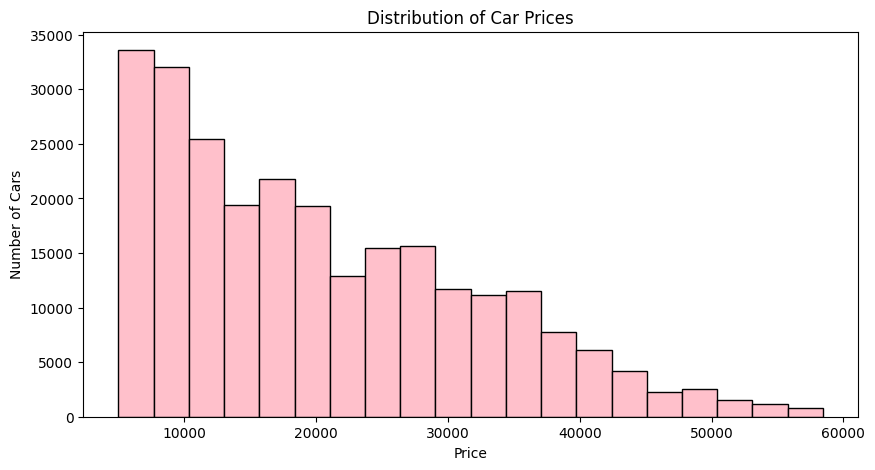

In [13]:
# Bar plot for price after removing outliers
plt.figure(figsize=(10, 5))
cleaned_data['price'].plot(kind='hist', bins=20, color='pink', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')

In [14]:
# The skewness implies that log transformation might help normalize price for regression models.
cleaned_data = cleaned_data.copy()
cleaned_data['log_price'] = np.log1p(cleaned_data['price'])

Text(0, 0.5, 'Number of Cars')

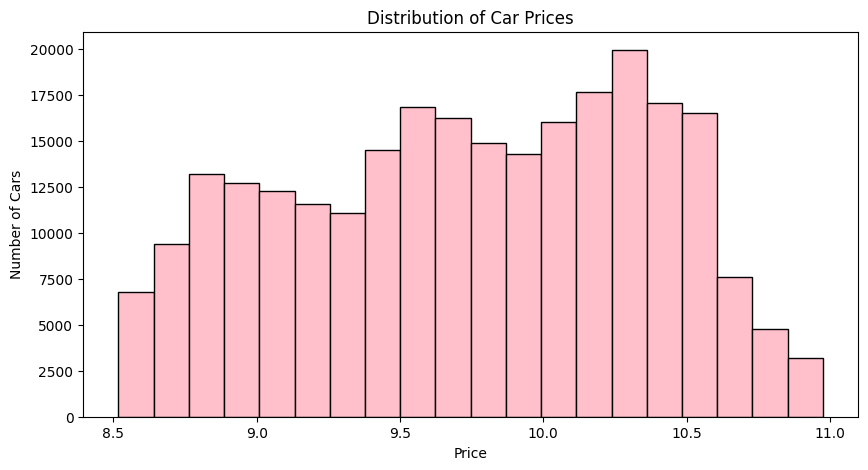

In [15]:
# Bar plot for price after after log transformation
plt.figure(figsize=(10, 5))
cleaned_data['log_price'].plot(kind='hist', bins=20, color='pink', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Number of Cars')

In [16]:
# working on year
cleaned_data['year'].unique()

array([2014., 2010., 2020., 2017., 2013., 2012., 2016., 2019., 2011.,
       2018., 2004., 2015., 2001., 2003., 2008., 2007., 2005., 2009.,
       2006., 2002., 1998., 2021., 1978., 1954., 1979., 1970., 1974.,
       2000., 1955., 1991., 1968., 1999., 1984., 1994., 1995., 1986.,
       1973., 1988., 1985., 1976., 1957., 1987., 1953., 1993., 1990.,
       1997., 1958., 1948., 1972., 1932., 1951., 1936., 1966., 1963.,
       1989., 1967., 1971., 1947., 1992., 1962., 1975., 1996., 1933.,
       1952., 1977., 1980., 1964., 1981., 1946., 1982., 1983., 1940.,
       1930., 1969., 1950., 1959., 1965., 1922., 1928., 1960., 1941.,
       1929., 1956., 1924., 1927., 1939., 1923., 1937., 1934., 1931.,
       1961., 1918., 1938., 1949., 1900., 2022., 1926., 1942., 1935.,
       1943., 1921., 1915., 1925., 1944., 1913., 1945.])

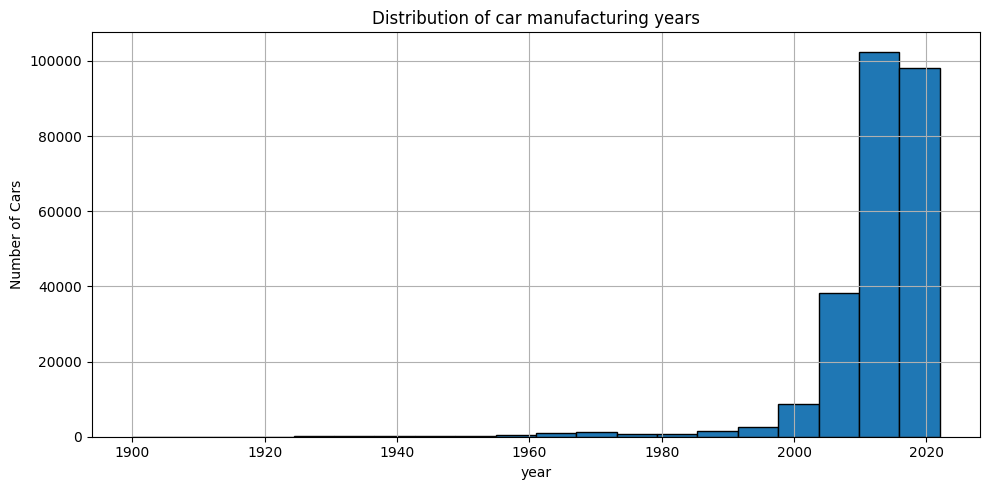

In [17]:
# Histogram to show the year
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data['year'], bins=20, edgecolor='black')
plt.title('Distribution of car manufacturing years')
plt.xlabel('year')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.tight_layout()
plt.show()

Key Observations:
Most cars in your dataset were made between 2005 and 2023, with the peak around 2015–2020.

There are a few entries before 1980, and even some before 1950 or as early as 1900, which are likely:

Data entry errors (e.g., missing or default year values).

Classic or antique vehicles (unusual in typical used car listings).

The small bump in the early 1900s is a red flag for cleaning.

In [18]:


# Define current year
current_year = datetime.now().year

# Filter the DataFrame to keep only realistic manufacturing years
cleaned_data = cleaned_data[(cleaned_data['year'] >= 1985) & (cleaned_data['year'] <= current_year)].copy()

cleaned_data.loc[:, 'car_age'] = current_year - cleaned_data['year']

# Dropping 'year' column to avoid multicollinearity and overfitting as 'car_age' and 'year' are perfectly correlated
cleaned_data.drop(columns=['year'], inplace=True, errors='ignore')
cleaned_data




,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,log_price,car_age
27,33590.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,NaN,pickup,white,al,10.422013,11.0
28,22590.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,NaN,pickup,blue,al,10.025307,15.0
29,39590.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,NaN,pickup,red,al,10.586357,5.0
30,30990.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,NaN,pickup,red,al,10.341452,8.0
31,15000.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,9.615872,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354263,18000.0,toyota,highlander,excellent,6 cylinders,gas,98472.0,clean,automatic,4wd,full-size,SUV,NaN,tn,9.798183,12.0
354265,21990.0,ford,escape titanium sport,good,nan,gas,14686.0,clean,other,fwd,NaN,other,red,tn,9.998389,8.0
354269,5400.0,ford,f-150,good,8 cylinders,gas,238205.0,clean,automatic,4wd,NaN,NaN,NaN,tn,8.594339,29.0
354270,18990.0,mercedes-benz,sl550,NaN,nan,gas,99000.0,clean,automatic,NaN,NaN,convertible,NaN,tn,9.851720,17.0


In [19]:
cleaned_data['condition'].unique()

array(['good', 'excellent', 'like new', 'new', nan, 'fair', 'salvage'],
      dtype=object)

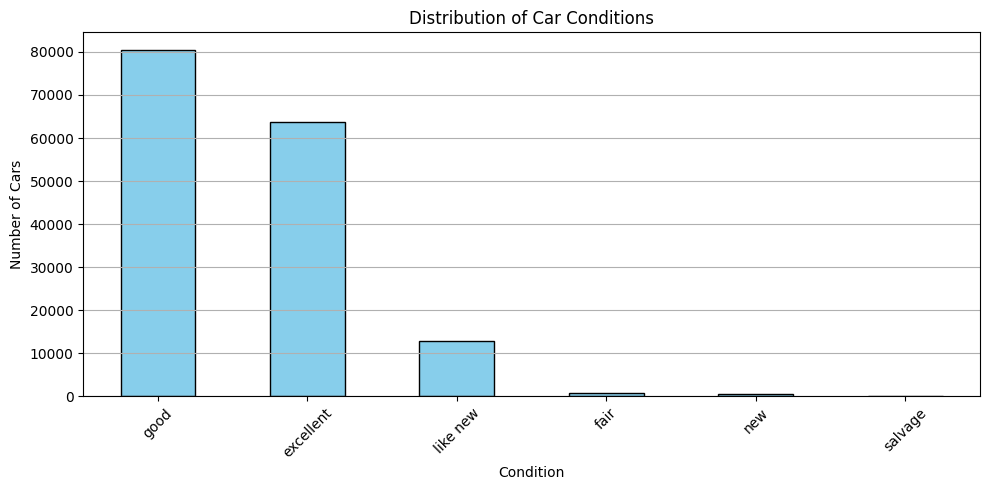

In [20]:
# Plot the distribution of conditions
plt.figure(figsize=(10, 5))
cleaned_data['condition'].value_counts().sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Car Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [21]:
# Since "good" is the most common condition, we can simply fill NaN values with "good"
cleaned_data['condition'] = cleaned_data['condition'].fillna('good')

In [22]:
cleaned_data['type'].unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'convertible', nan, 'wagon', 'van',
       'bus'], dtype=object)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

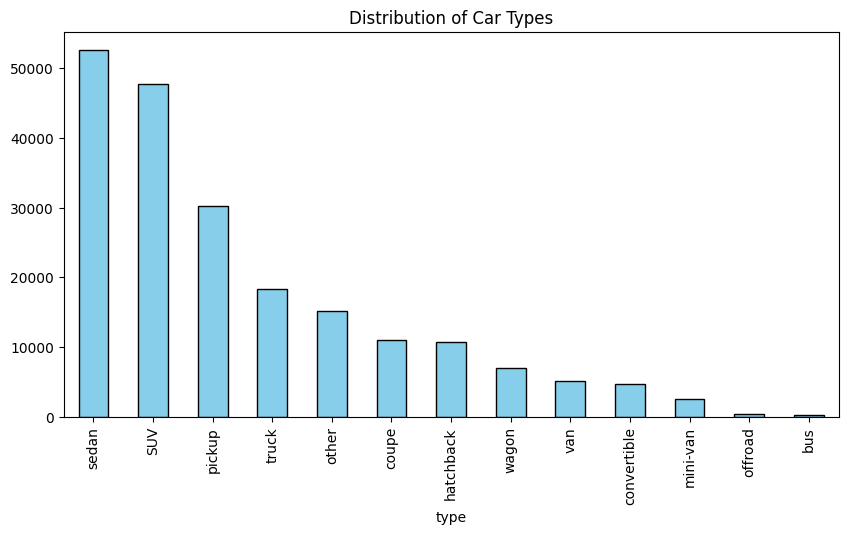

In [23]:
# Plot 'type'
plt.figure(figsize=(10, 5))
cleaned_data['type'].value_counts().sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Car Types')
plt

In [24]:
# fill NaN with 'other' to preserve neutrality and avoid misrepresentation.
cleaned_data['type'] = cleaned_data['type'].fillna('other')

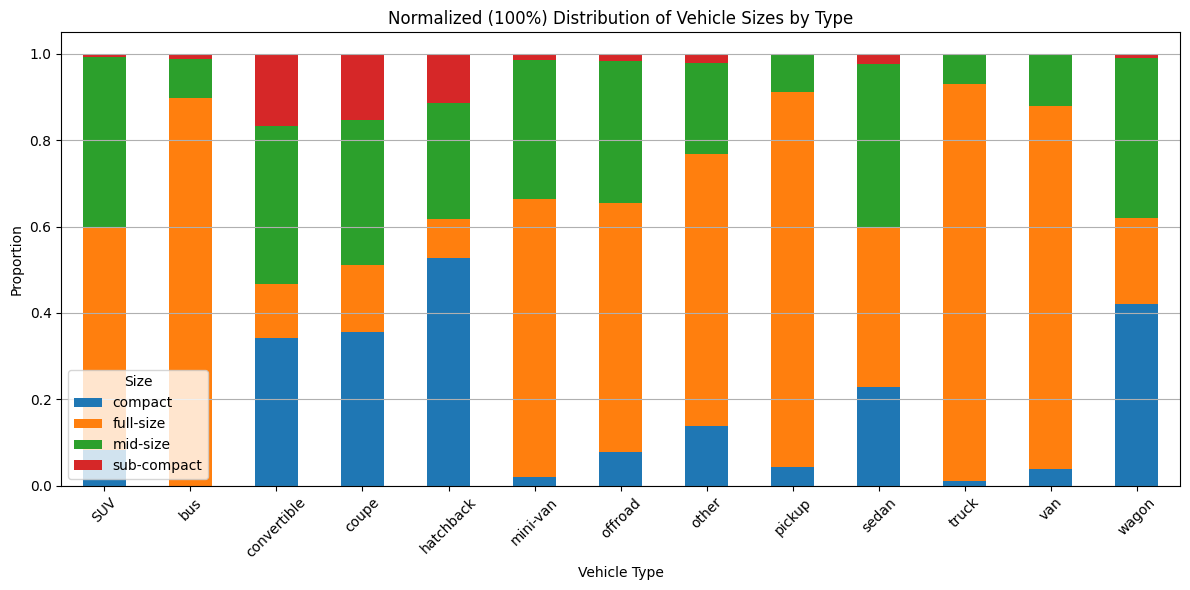

In [25]:
# Create a normalized crosstab
normalized_crosstab = pd.crosstab(cleaned_data['type'], cleaned_data['size'], normalize='index')

# Plot as 100% stacked bar chart
normalized_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Normalized (100%) Distribution of Vehicle Sizes by Type')
plt.ylabel('Proportion')
plt.xlabel('Vehicle Type')
plt.xticks(rotation=45)
plt.legend(title='Size')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Key Observations:
SUVs have a fairly balanced mix of mid-size and full-size, with some compact.

Buses are almost all full-size — expected.

Convertibles and coupes lean heavily toward compact and mid-size.

Hatchbacks are mostly compact (no surprise).

Mini-vans and vans are dominated by full-size.

Pickups and trucks are also mostly full-size (logical for work/commercial use).

Wagons show a more mixed size profile, with visible presence in all categories.



In [26]:
cleaned_data['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

In [27]:
# Define mapping from type → size
type_to_size = {
    'bus': 'full-size', 'offroad': 'full-size', 'mini-van': 'full-size',
    'van': 'full-size', 'wagon': 'full-size', 'truck': 'full-size', 'SUV': 'full-size',
    'hatchback': 'mid-size', 'sedan': 'mid-size',
    'convertible': 'compact', 'coupe': 'compact'
}

# Apply mapping where size is NaN
for car_type, size in type_to_size.items():
    cleaned_data.loc[(cleaned_data['size'].isna()) & (cleaned_data['type'] == car_type), 'size'] = size

# Fill remaining NaN with 'subcompact'
cleaned_data['size'] = cleaned_data['size'].fillna('sub-compact')

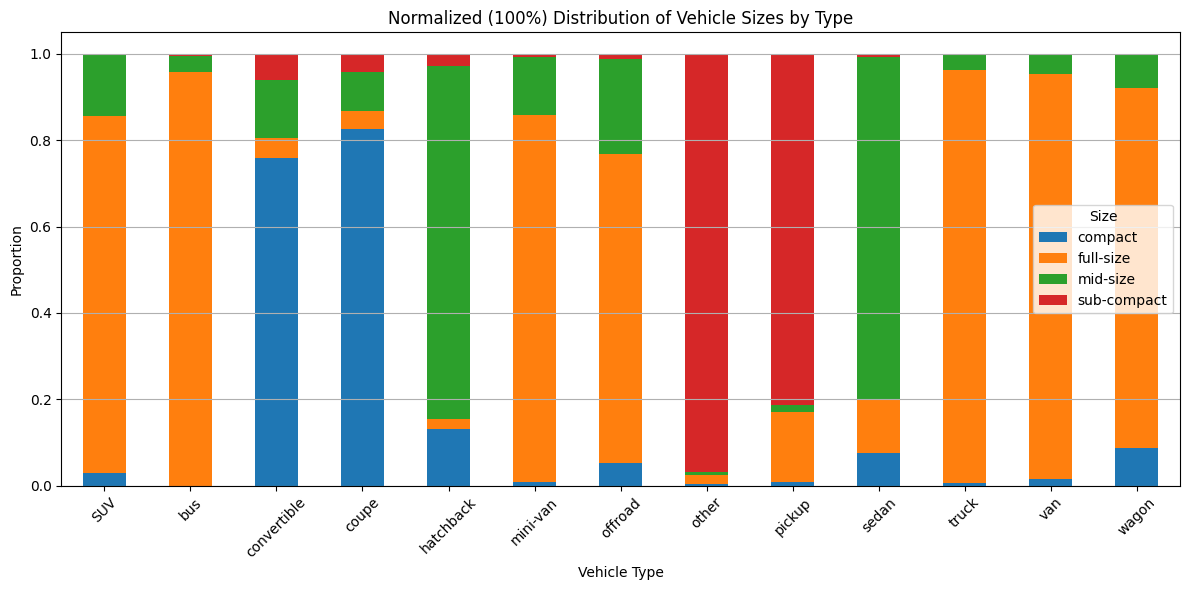

In [28]:
# Create a normalized crosstab
normalized_crosstab = pd.crosstab(cleaned_data['type'], cleaned_data['size'], normalize='index')

# Plot as 100% stacked bar chart
normalized_crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Normalized (100%) Distribution of Vehicle Sizes by Type')
plt.ylabel('Proportion')
plt.xlabel('Vehicle Type')
plt.xticks(rotation=45)
plt.legend(title='Size')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [29]:
cleaned_data['cylinders'].unique()

array(['8 cylinders', '6 cylinders', 'nan', '4 cylinders', '5 cylinders',
       '10 cylinders', '3 cylinders', 'other', '12 cylinders'],
      dtype=object)

In [30]:
cleaned_data = cleaned_data.replace('nan', np.nan)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

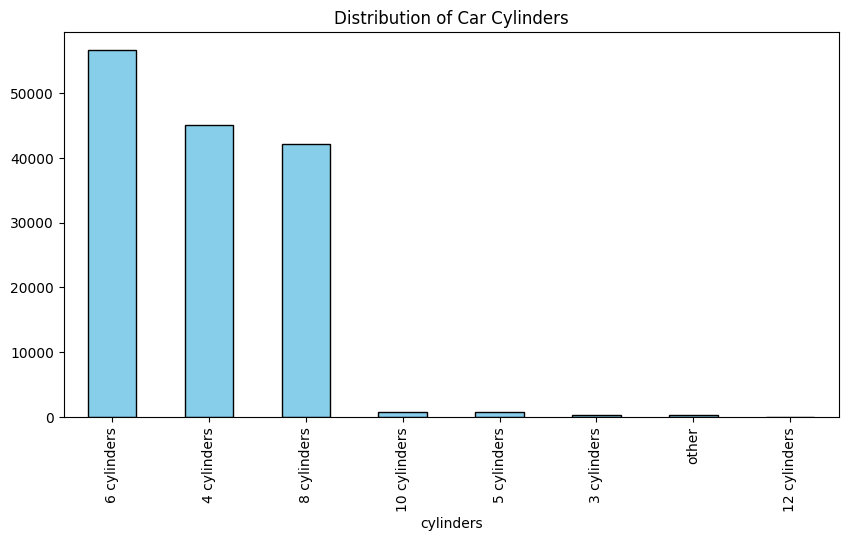

In [31]:
# Plot cylinder
plt.figure(figsize=(10, 5))
cleaned_data['cylinders'].value_counts().sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Car Cylinders')
plt

Interpretation:
Most common engines:

6 cylinders: ~84,000 cars — most popular, typically found in midsize sedans, SUVs, and trucks.

4 cylinders: ~70,000 cars — common for compact and fuel-efficient vehicles.

8 cylinders: ~63,000 cars — typical for trucks, performance, and luxury vehicles.

Rare configurations:

5, 10, 3, and 12 cylinders: each have only a small number of listings.

"other": this likely includes malformed entries (e.g., missing values or incorrect formats that weren’t cleaned properly).



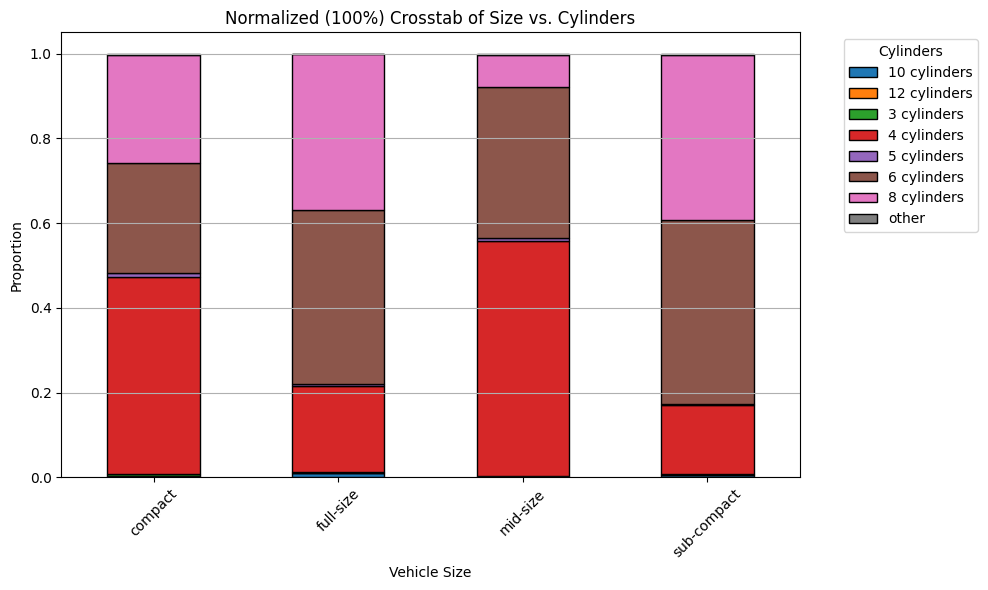

In [32]:
# Create normalized crosstab: rows = size, columns = cylinders, normalized by row (index)
crosstab_normalized = pd.crosstab(
    cleaned_data['size'],
    cleaned_data['cylinders'],
    normalize='index'
)

# Plot normalized stacked bar chart
crosstab_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black')
plt.title('Normalized (100%) Crosstab of Size vs. Cylinders')
plt.xlabel('Vehicle Size')
plt.ylabel('Proportion')
plt.legend(title='Cylinders', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [33]:
# Define mapping from size → default cylinders
size_to_cylinders = {
    'full-size': '6 cylinders',
    'mid-size': '5 cylinders',
    'compact': '4 cylinders',
    'sub-compact': '4 cylinders',
    'mini-van': '6 cylinders',
    'wagon': '5 cylinders',
    'van': '6 cylinders',
    'other': '4 cylinders'  # generic fallback for unusual categories
}

# Filter rows with NaN in 'cylinders'
nan_cylinders_df = cleaned_data[cleaned_data['cylinders'].isna()].copy()

# Apply the mapping based on 'size', fallback to 4
nan_cylinders_df['cylinders'] = nan_cylinders_df['size'].map(size_to_cylinders).fillna('4 cylinders')

# Update the original DataFrame
cleaned_data.loc[nan_cylinders_df.index, 'cylinders'] = nan_cylinders_df['cylinders']


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

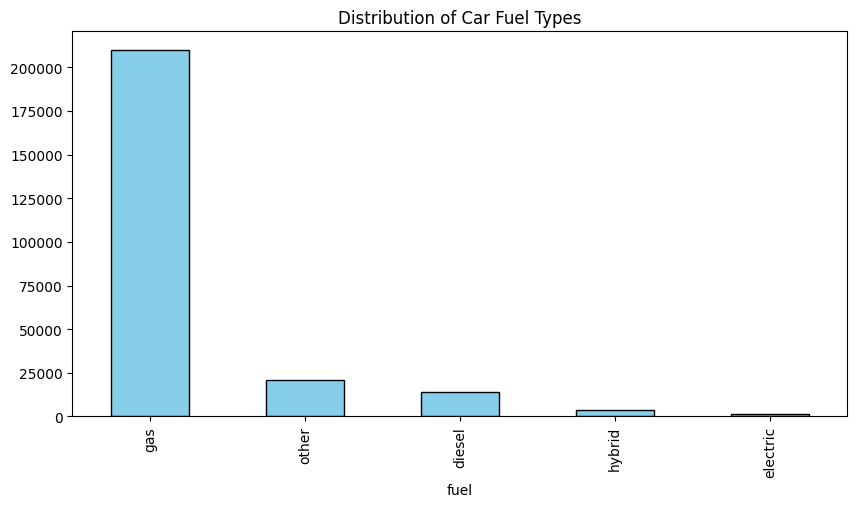

In [34]:
# Plot fuel
plt.figure(figsize=(10, 5))
cleaned_data['fuel'].value_counts().sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Car Fuel Types')
plt

In [35]:
# fill NaN values for 'fuel' with gas
default_fuel = cleaned_data['fuel'].mode()[0]
cleaned_data['fuel'] = cleaned_data['fuel'].fillna(default_fuel)

In [36]:
# Used cars having odometer reading below 5000 is unlikely so converting them to NaN
cleaned_data = cleaned_data.copy()
#cleaned_data.loc[cleaned_data['odometer'] < 5000, 'odometer'] = np.nan
# replace odometer values with NaN only if the odometer is less than 5000 and the car is not new
cleaned_data.loc[
    (cleaned_data['odometer'] < 5000) & (cleaned_data['condition'] != 'new'),
    'odometer'
] = np.nan

In [37]:
cleaned_data[(cleaned_data['condition'] == 'new') & (cleaned_data['odometer'] < 5000)]

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,log_price,car_age
1824,49900.0,lexus,rx 450h,new,6 cylinders,hybrid,1900.0,clean,automatic,4wd,full-size,SUV,white,al,10.817796,6.0
4018,33500.0,chevrolet,express 2500,new,4 cylinders,gas,3200.0,clean,automatic,NaN,sub-compact,other,white,al,10.419331,5.0
5107,49900.0,dodge,grand caravan,new,6 cylinders,gas,26.0,clean,automatic,fwd,full-size,mini-van,white,ak,10.817796,6.0
7368,49900.0,dodge,grand caravan,new,6 cylinders,gas,26.0,clean,automatic,fwd,full-size,mini-van,white,ak,10.817796,6.0
9256,55325.0,kia,telluride,new,6 cylinders,gas,52.0,clean,automatic,4wd,full-size,other,white,az,10.920998,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328514,33200.0,ford,fusion titanium,new,4 cylinders,gas,714.0,clean,automatic,fwd,mid-size,sedan,red,pa,10.410335,5.0
335616,54500.0,chevrolet,camaro zl1,new,6 cylinders,gas,2087.0,clean,manual,rwd,mid-size,coupe,orange,pa,10.905974,12.0
338055,55374.0,toyota,tundra trd pro,new,8 cylinders,gas,2.0,clean,automatic,4wd,sub-compact,other,NaN,pa,10.921884,4.0
341792,39500.0,ford,thunderbird,new,8 cylinders,gas,1304.0,clean,automatic,rwd,compact,convertible,green,ri,10.584081,23.0


In [38]:
# Fill NaN values in 'odometer' column with the median
cleaned_data['odometer'] = cleaned_data['odometer'].fillna(cleaned_data['odometer'].median())
cleaned_data['odometer'].describe()

,odometer
count,2.518910e+05
mean,8.884248e+04
std,9.419655e+04
min,0.000000e+00
25%,4.033200e+04
50%,8.224900e+04
75%,1.236780e+05
max,1.000000e+07


In [39]:
# Remove outliers from 'odometer' column and keep only the values that fall in 'interquartile range'(IQR)
# Compute IQR bounds
cleaned_data = cleaned_data.copy()
Q1 = cleaned_data['odometer'].quantile(0.25)
Q3 = cleaned_data['odometer'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a new column for cleaned odometer
cleaned_data['odometer'] = cleaned_data['odometer'].where(
    (cleaned_data['odometer'] >= lower_bound) &
    (cleaned_data['odometer'] <= upper_bound)
)

# Fill NaN values in 'odometer' column with the median
cleaned_data['odometer'] = cleaned_data['odometer'].fillna(cleaned_data['odometer'].median())

cleaned_data['odometer'].describe()

,odometer
count,251891.000000
mean,85814.125098
std,52656.986505
min,0.000000
25%,40332.000000
50%,82249.000000
75%,121747.000000
max,248634.000000


In [40]:
cleaned_data[(cleaned_data['condition'] == 'new') & (cleaned_data['odometer'] < 5000)]

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,log_price,car_age
1824,49900.0,lexus,rx 450h,new,6 cylinders,hybrid,1900.0,clean,automatic,4wd,full-size,SUV,white,al,10.817796,6.0
4018,33500.0,chevrolet,express 2500,new,4 cylinders,gas,3200.0,clean,automatic,NaN,sub-compact,other,white,al,10.419331,5.0
5107,49900.0,dodge,grand caravan,new,6 cylinders,gas,26.0,clean,automatic,fwd,full-size,mini-van,white,ak,10.817796,6.0
7368,49900.0,dodge,grand caravan,new,6 cylinders,gas,26.0,clean,automatic,fwd,full-size,mini-van,white,ak,10.817796,6.0
9256,55325.0,kia,telluride,new,6 cylinders,gas,52.0,clean,automatic,4wd,full-size,other,white,az,10.920998,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328514,33200.0,ford,fusion titanium,new,4 cylinders,gas,714.0,clean,automatic,fwd,mid-size,sedan,red,pa,10.410335,5.0
335616,54500.0,chevrolet,camaro zl1,new,6 cylinders,gas,2087.0,clean,manual,rwd,mid-size,coupe,orange,pa,10.905974,12.0
338055,55374.0,toyota,tundra trd pro,new,8 cylinders,gas,2.0,clean,automatic,4wd,sub-compact,other,NaN,pa,10.921884,4.0
341792,39500.0,ford,thunderbird,new,8 cylinders,gas,1304.0,clean,automatic,rwd,compact,convertible,green,ri,10.584081,23.0


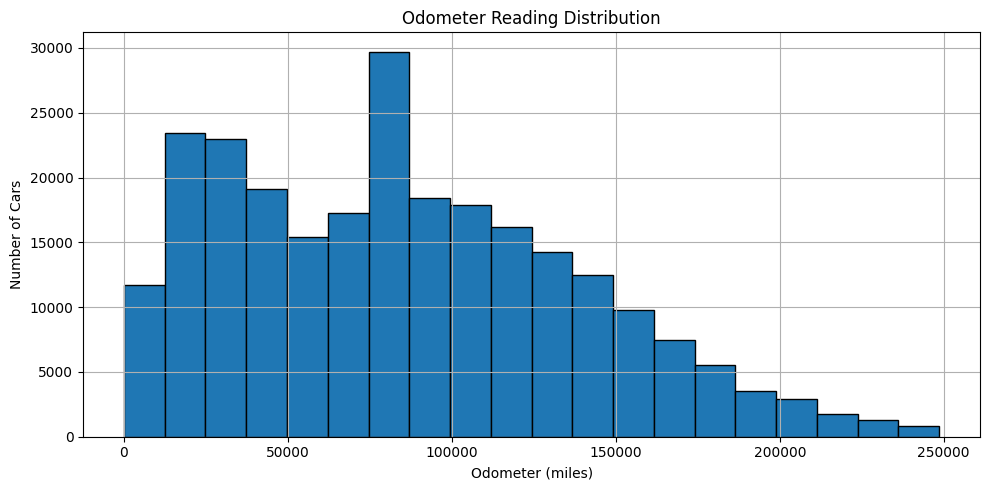

In [41]:
# Histogram to show the odometer reading
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data['odometer'], bins=20, edgecolor='black')
plt.title('Odometer Reading Distribution')
plt.xlabel('Odometer (miles)')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
cleaned_data['title_status'].unique()

array(['clean', 'rebuilt', 'lien', nan, 'salvage', 'missing',
       'parts only'], dtype=object)

In [43]:
# count of 'title_status'
cleaned_data['title_status'].value_counts()

,count
title_status,
clean,240135
rebuilt,4399
salvage,2119
lien,931
missing,45
parts only,15


In [44]:
# clean is overwhelmingly dominant
cleaned_data['title_status'] = cleaned_data['title_status'].fillna('clean')

In [45]:
cleaned_data['transmission'].value_counts()

,count
transmission,
automatic,190771
other,49070
manual,10734


In [46]:
# fill NaN values for 'transmission' with 'automatic'
cleaned_data['transmission'] = cleaned_data['transmission'].fillna('automatic')


In [47]:
cleaned_data['paint_color'].value_counts()

,count
paint_color,
white,49820
black,41086
silver,26852
blue,18824
red,18433
grey,14781
brown,3734
custom,3708
green,3459


In [48]:
cleaned_data['paint_color'] = cleaned_data['paint_color'].fillna('unknown')

In [49]:
cleaned_data['drive'].value_counts()

,count
drive,
4wd,81442
fwd,62440
rwd,33317


In [50]:
# Calculate percentage of missing values in 'drive'
missing_percentage = cleaned_data['drive'].isna().mean() * 100
missing_percentage

np.float64(29.65250842626374)

In [51]:
cleaned_data['drive'] = cleaned_data['drive'].fillna('missing')

In [52]:
cleaned_data.isna().sum()

,0
price,0
manufacturer,0
model,0
condition,0
cylinders,0
fuel,0
odometer,0
title_status,0
transmission,0
drive,0


In [53]:
cleaned_data['condition'].unique()

array(['good', 'excellent', 'like new', 'new', 'fair', 'salvage'],
      dtype=object)

In [54]:
# Clean 'model' column
cleaned_data['model'] = cleaned_data['model'].str.lower()

# Step 1: Lowercase, strip whitespace, remove non-alphanumeric (except spaces)
cleaned_data['model'] = cleaned_data['model'].astype(str).str.lower().str.strip()
cleaned_data['model'] = cleaned_data['model'].apply(lambda x: re.sub(r'[^a-z0-9 ]', '', x))

# Step 2: Collapse multiple spaces
cleaned_data['model'] = cleaned_data['model'].apply(lambda x: re.sub(r'\s+', ' ', x))

In [55]:
# Reduce cardinality for 'model' and 'manufacturer'

filtered_data = cleaned_data.copy()

top_models = cleaned_data['model'].value_counts().nlargest(100).index
filtered_data['model'] = cleaned_data['model'].where(cleaned_data['model'].isin(top_models), other='other')

top_manufacturers = cleaned_data['manufacturer'].value_counts().nlargest(50).index
filtered_data['manufacturer'] = cleaned_data['manufacturer'].where(cleaned_data['manufacturer'].isin(top_manufacturers), other='other')

filtered_data

,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,log_price,car_age
27,33590.0,gmc,other,good,8 cylinders,gas,57923.0,clean,other,missing,sub-compact,pickup,white,al,10.422013,11.0
28,22590.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,missing,sub-compact,pickup,blue,al,10.025307,15.0
29,39590.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,missing,sub-compact,pickup,red,al,10.586357,5.0
30,30990.0,toyota,other,good,8 cylinders,gas,41124.0,clean,other,missing,sub-compact,pickup,red,al,10.341452,8.0
31,15000.0,ford,f150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,al,9.615872,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354263,18000.0,toyota,highlander,excellent,6 cylinders,gas,98472.0,clean,automatic,4wd,full-size,SUV,unknown,tn,9.798183,12.0
354265,21990.0,ford,other,good,4 cylinders,gas,14686.0,clean,other,fwd,sub-compact,other,red,tn,9.998389,8.0
354269,5400.0,ford,f150,good,8 cylinders,gas,238205.0,clean,automatic,4wd,sub-compact,other,unknown,tn,8.594339,29.0
354270,18990.0,mercedes-benz,other,good,4 cylinders,gas,99000.0,clean,automatic,missing,compact,convertible,unknown,tn,9.851720,17.0


In [56]:
# Export cleaned dataset to CSV
export_path = "/content/data/optimized_cleaned_vehicle_dataset.csv"
filtered_data.to_csv(export_path, index=False)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [57]:
# Final features and target
X = filtered_data.drop(columns=['price', 'log_price'])
y = filtered_data['log_price']

X.shape, y.shape

((251891, 14), (251891,))

In [58]:
# Split the cleaned data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(201512, 14) (50379, 14) (201512,) (50379,)


In [59]:
# 'cylinders' contains both str and int
#X['cylinders'] = X['cylinders'].astype(str)  # Convert to string

# Building a preprocessing pipeline
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
# 'cylinders' contains both str and int
X['cylinders'] = X['cylinders'].astype(str)  # Convert to string

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


Numerical columns: Index(['odometer', 'car_age'], dtype='object')
Categorical columns: Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object')


In [60]:
# Define models

# Linear Regression pipeline
linear_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Ridge Regression pipeline
ridge_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

# Lasso Regression pipeline
lasso_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", Lasso(alpha=0.001))
])


In [61]:
# Parameter grid
param_grid = {
    "regressor__alpha": [0.001, 0.01, 0.1, 1, 10]
}

# Grid search
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

# Predict on test set
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Summarize results
results = {
    "Best alpha": grid_search.best_params_["regressor__alpha"],
    "CV RMSE (mean)": -grid_search.best_score_,
    "Test RMSE": rmse,
    "Test R²": r2
}

results_df = pd.DataFrame(results, index=[0])
results_df


,Best alpha,CV RMSE (mean),Test RMSE,Test R²
0,0.001,0.326658,0.328622,0.713595


In [62]:
# Train the model
linear_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['odometer', 'car_age'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [63]:
ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['odometer', 'car_age'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object'))])),
                ('regressor', Ridge())])

In [64]:
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['odometer', 'car_age'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
       'state'],
      dtype='object'))])),
                ('regressor', Lasso(alpha=0.001))])

In [65]:
# After defining the three pipelines — linear_model, ridge_model, and lasso_model — the next step is to:
# Fit them on your training data
# Predict on the test set
# Calculate RMSE and R² score for each

# Define a helper function
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    #model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"   {name}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   R²:   {r2:.4f}")
    print("-" * 30)

# Evaluate all models
evaluate_model("Linear Regression", linear_model, X_train, X_test, y_train, y_test)
evaluate_model("Ridge Regression", ridge_model, X_train, X_test, y_train, y_test)
evaluate_model("Lasso Regression", lasso_model, X_train, X_test, y_train, y_test)


   Linear Regression
   RMSE: 0.31
   R²:   0.7456
------------------------------
   Ridge Regression
   RMSE: 0.31
   R²:   0.7455
------------------------------
   Lasso Regression
   RMSE: 0.33
   R²:   0.7136
------------------------------


In [66]:
def get_feature_names(preprocessor, numerical_cols, categorical_cols):
    num_features = numerical_cols
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    return np.concatenate([num_features, cat_features])

In [67]:
def extract_feature_importance(model, model_name, feature_names):
    regressor = model.named_steps['regressor']
    coefs = regressor.coef_

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coeff': np.abs(coefs)
    }).sort_values(by='abs_coeff', ascending=False)

    print(f"\n📊 Top features for {model_name}")
    display(importance_df.head(10))  # Top 10 important features

    return importance_df

In [68]:
# Fit the preprocessor first
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor, numerical_cols, categorical_cols)

# Now extract for each model
linear_importance = extract_feature_importance(linear_model, "Linear Regression", feature_names)
ridge_importance = extract_feature_importance(ridge_model, "Ridge Regression", feature_names)
lasso_importance = extract_feature_importance(lasso_model, "Lasso Regression", feature_names)


📊 Top features for Linear Regression


,feature,coefficient,abs_coeff
12,manufacturer_ferrari,1.819250,1.819250
4,manufacturer_aston-martin,0.923260,0.923260
67,model_corvette,0.570069,0.570069
13,manufacturer_fiat,-0.500196,0.500196
38,manufacturer_tesla,0.460657,0.460657
86,model_focus,-0.436219,0.436219
110,model_patriot,-0.429580,0.429580
33,manufacturer_porsche,0.423695,0.423695
157,fuel_diesel,0.423124,0.423124
28,manufacturer_mercury,-0.412037,0.412037



📊 Top features for Ridge Regression


,feature,coefficient,abs_coeff
4,manufacturer_aston-martin,0.587999,0.587999
67,model_corvette,0.567763,0.567763
38,manufacturer_tesla,0.506004,0.506004
165,title_status_parts only,-0.481929,0.481929
33,manufacturer_porsche,0.470868,0.470868
13,manufacturer_fiat,-0.448682,0.448682
86,model_focus,-0.434561,0.434561
110,model_patriot,-0.428844,0.428844
157,fuel_diesel,0.423054,0.423054
68,model_cruze,-0.408901,0.408901



📊 Top features for Lasso Regression


,feature,coefficient,abs_coeff
157,fuel_diesel,0.448553,0.448553
1,car_age,-0.281018,0.281018
67,model_corvette,0.280195,0.280195
0,odometer,-0.222301,0.222301
183,type_hatchback,-0.220495,0.220495
162,title_status_clean,0.216081,0.216081
30,manufacturer_mitsubishi,-0.205132,0.205132
24,manufacturer_lexus,0.186943,0.186943
22,manufacturer_kia,-0.182601,0.182601
138,model_wrangler,0.180389,0.180389


In [79]:
# Function to plot predicted vs actual 'price'

def plot_predicted_vs_actual(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    # Convert log(price) back to actual price
    y_actual = np.exp(y_test)
    y_predicted = np.exp(y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5, color='skyblue', edgecolor='k')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')  # ideal line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

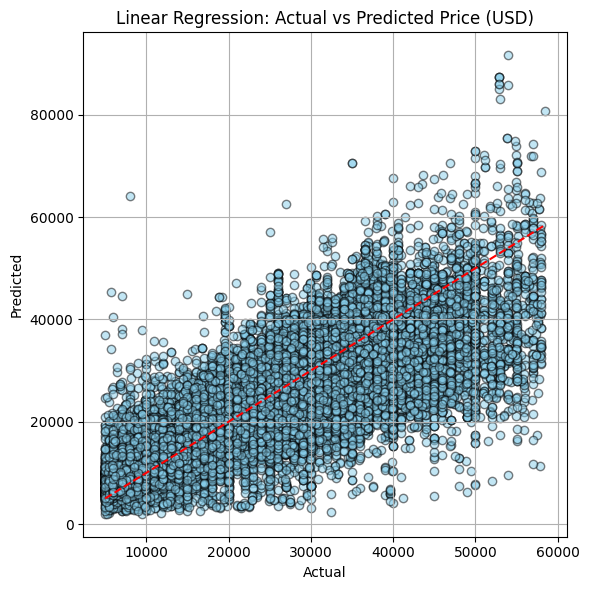

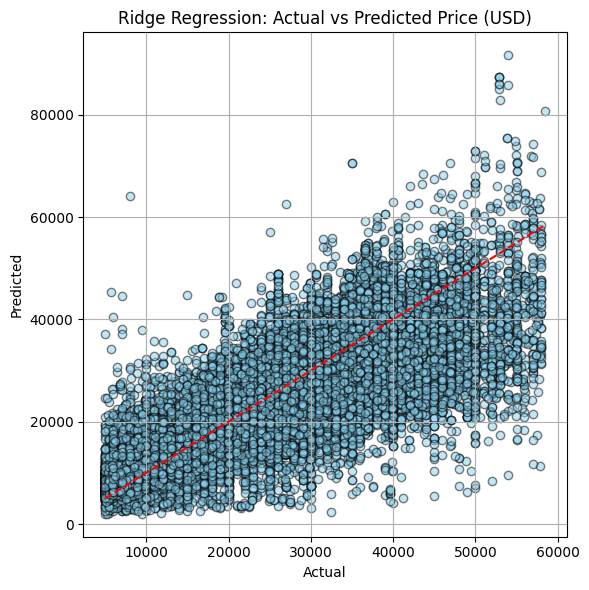

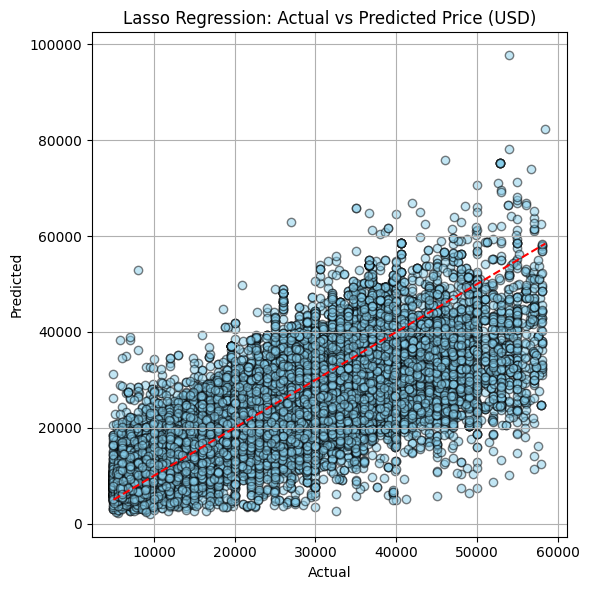

In [81]:
# Plot results
plot_predicted_vs_actual(linear_model, X_test, y_test, "Linear Regression: Actual vs Predicted Price (USD)")
plot_predicted_vs_actual(ridge_model, X_test, y_test, "Ridge Regression: Actual vs Predicted Price (USD)")
plot_predicted_vs_actual(lasso_model, X_test, y_test, "Lasso Regression: Actual vs Predicted Price (USD)")

In [86]:
# Combine X_train with y_train for correlation calculation
train_data = X_train.copy()
train_data['price'] = y_train  # Or 'log_price' depending on what you're predicting

# Compute correlation matrix and extract correlations with 'price'
correlations = train_data.corr(numeric_only=True)['price'].drop('price')

# Sort by absolute correlation
sorted_corr = correlations.abs().sort_values(ascending=False)

# Print results
print("Features most correlated with price (log_price):\n")
print(sorted_corr)

Features most correlated with price (log_price):

car_age     0.576322
odometer    0.565288
Name: price, dtype: float64


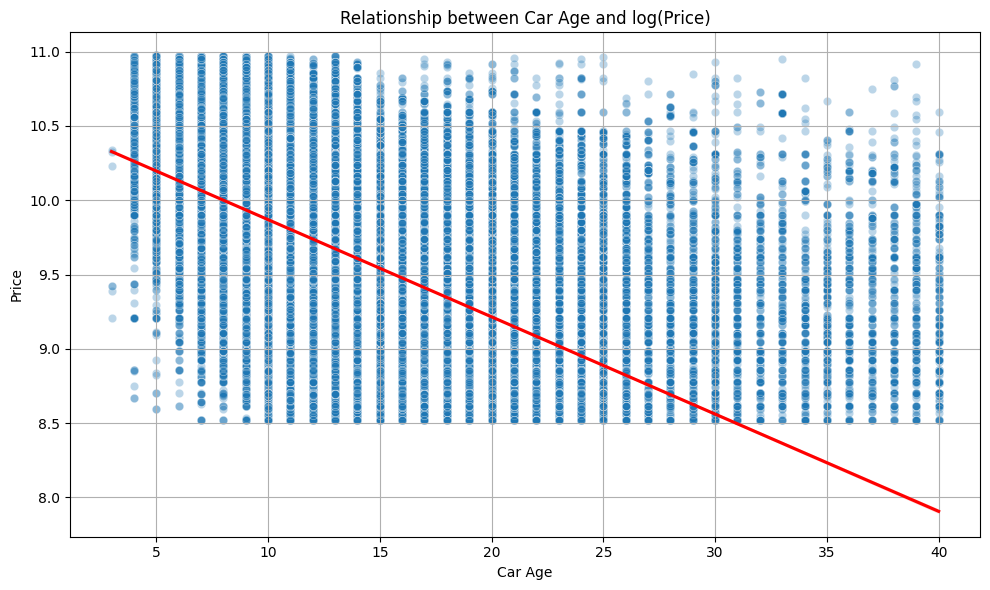

In [72]:
# Plotting the relationship between car age and log price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x="car_age", y="log_price", alpha=0.3)
sns.regplot(data=filtered_data, x="car_age", y="log_price", scatter=False, color="red")
plt.title("Relationship between Car Age and log(Price)")
plt.xlabel("Car Age")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

The y-axis ranges from ~8.0 to ~11.0

These correspond to prices like:

exp(8.0)≈ $2,980

exp(11.0)≈ $59,874


This suggests that the price of the cars ranges from ~$3k to ~$60k, which is realistic for used car markets.

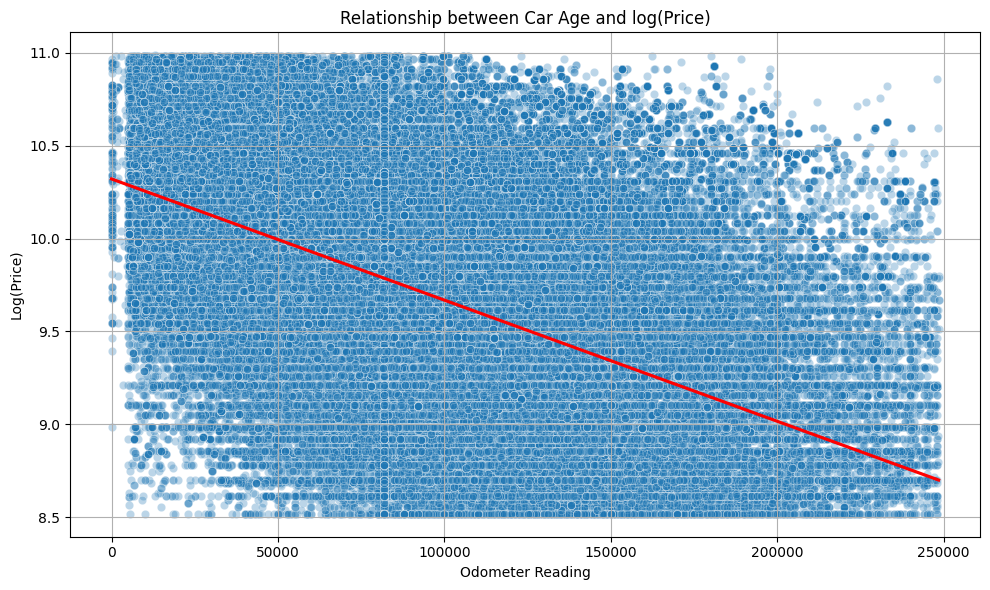

In [91]:
# Plotting the relationship between car age and log price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x="odometer", y="log_price", alpha=0.3)
sns.regplot(data=filtered_data, x="odometer", y="log_price", scatter=False, color="red")
plt.title("Relationship between Car Age and log(Price)")
plt.xlabel("Odometer Reading")
plt.ylabel("Log(Price)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
# Store correlation results
cat_corr = {}

# Loop through each categorical column
for col in X_train.select_dtypes(include="object").columns:
    # Map each category to the mean price
    mean_encoded = X_train[col].map(train_data.groupby(col)['price'].mean())
    # Compute correlation with price
    corr = mean_encoded.corr(y_train)
    cat_corr[col] = abs(corr)

# Sort by absolute correlation value
cat_corr_sorted = dict(sorted(cat_corr.items(), key=lambda x: x[1], reverse=True))

# Display results
print("Categorical features ranked by correlation with price:\n")
for k, v in cat_corr_sorted.items():
    print(f"{k:<20} →  Correlation: {v:.4f}")

Categorical features ranked by correlation with price:

transmission         →  Correlation: 0.3770
model                →  Correlation: 0.3442
manufacturer         →  Correlation: 0.3268
type                 →  Correlation: 0.3208
drive                →  Correlation: 0.2720
fuel                 →  Correlation: 0.2638
condition            →  Correlation: 0.2351
cylinders            →  Correlation: 0.1742
paint_color          →  Correlation: 0.1672
size                 →  Correlation: 0.1559
state                →  Correlation: 0.1473
title_status         →  Correlation: 0.0962


<Figure size 1000x600 with 0 Axes>

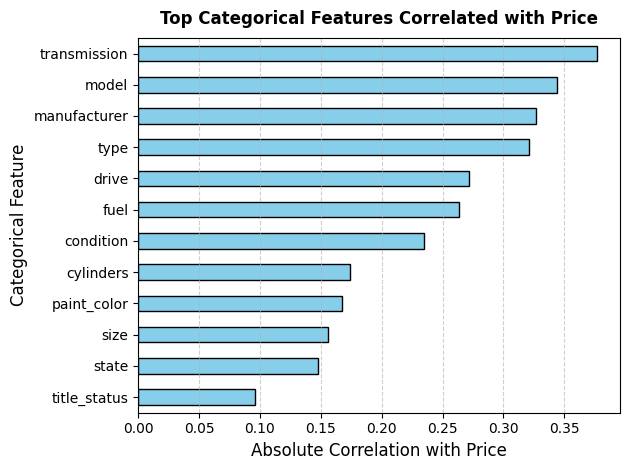

In [84]:
# Convert to DataFrame for easier plotting

cat_corr_df = pd.DataFrame.from_dict(cat_corr, orient='index', columns=['correlation'])
cat_corr_df.sort_values(by='correlation', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
cat_corr_df.plot(kind='barh', legend=False, color='skyblue', edgecolor='black')
plt.title("Top Categorical Features Correlated with Price", fontsize=12, fontweight='bold', pad=10)
plt.xlabel("Absolute Correlation with Price", fontsize=12)
plt.ylabel("Categorical Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#Key Drivers of Car Price
##Top Numerical Features (by correlation with log(price)):

###Feature	Correlation
#####car_age	0.576
####odometer	0.565
<I>These are the strongest continuous indicators: newer, low-mileage cars are more expensive, as expected.<I>

#**Top Categorical Features:**

* transmission         →  Automatic vs. manual affects perceived value
* model                →  Specific models vary widely in value
* manufacturer         →  Brand equity plays a major role
* type                 →  SUV, sedan, truck classification influences price
* drive                →  AWD/4WD tends to raise price
* fuel,condition,
cylinders,paint_color,
size,state,
title_status         →  Varying influence depending on market segment and consumer perception


# **Recommendations for the Client**

1.   Prioritize acquiring cars that are:
  * Newer with lower mileage

  * Good condition

  * From strong brands with consistent resale value (e.g., Toyota, Ford, Honda)

  * Equipped with automatic transmission, AWD, or hybrid/electric drivetrains

2.  De-emphasize inventory with:

  * High mileage + older age combinations

  * Poor title history (e.g., salvage)

  * Unpopular configurations (e.g., manual trucks in urban markets)

3. Use the model to:

  * Price cars intelligently, using predicted value bands

  * Spot underpriced inventory for sourcing opportunities

  * Inform online pricing platforms with fair-market logic

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

#**Objective**
The goal of this project was to uncover key factors that influence used car prices, allowing your dealership to:

* Price inventory more competitively

* Identify undervalued acquisition opportunities

* Understand what consumers value most when purchasing used vehicles

We used data from over 426K used car listings across the United States to build and evaluate predictive models that explain what drives price and how much.



### Key Drivers of Used Car Price

| **Feature**        | **Insight** |
|--------------------|-------------|
| **Car Age**        | Newer cars command higher prices — strong linear depreciation effect |
| **Odometer**       | Lower mileage strongly correlates with higher price |
| **Transmission**   | Automatics are generally priced higher than manuals |
| **Brand & Model**  | Brands like Toyota, Honda, Ford, and premium models retain more value |
| **Vehicle Type**   | SUVs and trucks are priced higher than sedans and compacts |
| **Drive Type**     | AWD/4WD adds value, especially in regions with harsh weather |
| **Condition**      | “Excellent” and “Like New” vehicles sell for a premium |


### Model Summary

We trained multiple models to predict used car prices and selected the best one based on accuracy and interpretability.

| **Model**           | **Accuracy (R²)** | **Error (RMSE, log-scale)** | **Notes**                                                   |
|---------------------|-------------------|------------------------------|--------------------------------------------------------------|
| Linear Regression   | 74.6%             | 0.31                         | Simple, effective baseline                                   |
| Ridge Regression    | 74.5%             | 0.31                         | Slightly more stable with similar performance                |
| Lasso Regression    | 71.4%             | 0.33                         | Useful for feature reduction but underperforms slightly      |

These models predict within **±30%** of actual price for most listings.


### Business Recommendations

#### Focus Inventory On:
- Newer vehicles with under 100,000 miles  
- Clean titles and good condition  
- Known value-retaining brands like **Toyota, Honda, Ford**

#### Be Selective With:
- High-mileage or very old inventory  
- Salvage/rebuilt title vehicles  
- Manual transmission models *(unless niche demand exists)*

#### Pricing Strategy:
- Use **predicted price ranges** to benchmark listings  
- Reprice inventory that significantly deviates from market value  
- Adjust prices based on **region**, **drive type**, and **seasonal trends**


# Next Steps and Recommendation
We recommend exploring:

* Nonlinear models (e.g., Random Forest or XGBoost) for further improvement

* Real-time integration into pricing workflows

* Enhanced visual dashboards for sales team use

